In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Check sparsification

In [2]:
def histogram_params(model, xscale, abs=True):
    params = torch.cat([x.flatten() for x in model.parameters()]) # compress weights into 1-D

    if abs:
        params = torch.abs(params)

    hist_values, bin_edges = torch.histogram(params, bins=300, range=xscale)
    hist_values = hist_values.detach().numpy()
    bin_edges = bin_edges.detach().numpy()
    width = np.diff(bin_edges)
    return (hist_values, bin_edges, width)

def weights_dist_normal(model_name, model, save=True):
    '''
    plot disitribution of weights on nomal scale
    '''
    hist_values, bin_edges, width = histogram_params(model, (-1,1), abs=False)

    plt.bar(bin_edges[:-1], hist_values, width)
    plt.title(f'{model_name}: Distribution of Weights on Nomal Scale')
    plt.xlabel("Weights")
    plt.ylabel("Counts")
    if save:
        plt.savefig(f"plots/{model_name}_weights_dist_normal.png", dpi=199)
    plt.show()


def weights_dist_log(model_name, model, save=True):
    '''
    plot disitribution of weights on log scale
    '''
    hist_values, bin_edges, width = histogram_params(model, (0,1))

    plt.bar(bin_edges[:-1], hist_values, width)
    plt.xscale('log')
    plt.title(f'{model_name}: Distribution of Weights on Log Scale')
    plt.xlabel("Weights (Log of Absolute Value)")
    plt.ylabel("Counts")
    plt.vlines(x = 1e-2, ymin = 0, ymax = np.max(hist_values), colors = 'red')
    plt.vlines(x = 1e-1, ymin = 0, ymax = np.max(hist_values), colors = 'red')
    if save:
        plt.savefig(f"plots/{model_name}_weights_dist_log.png", dpi=199)
    plt.show()


def sparsity_overall(model):
    '''
    Assess sparsity on overall structure
    '''
    thresholds = [1e-2, 1e-1]
    params = torch.cat([x.flatten() for x in model.parameters()]) # compress weights into 1-D
    abs_params = torch.abs(params).detach().numpy()

    for thresold in thresholds:
        counts = (abs_params < thresold).sum()
        percent = round(counts/len(abs_params)*100, 2)
        print(f'{percent}% of total weights < {thresold}')

    percent = round((len(abs_params)-counts)/len(abs_params)*100, 2)
    print(f'{percent}% of total weights >= {thresholds[-1]}')


def sparsity_layers(model_name, module_list, save=True):
    '''
    Assess sparsity per layer and plot
    '''
    thresholds = [1e-2, 1e-1]
    layers = []

    for idx, layer in enumerate(module_list):
        cur = [idx]

        params = torch.cat([x.flatten() for x in layer.parameters()])
        abs_params = torch.abs(params).detach().numpy()

        counts = 0
        
        for thresold in thresholds:
            counts = (abs_params < thresold).sum()
            percent = round(counts/len(abs_params)*100, 2)
            cur.append(percent)

        percent = round((len(abs_params)-counts)/len(abs_params)*100, 2)
        cur.append(percent)
        layers.append(cur)
        
    df = pd.DataFrame(layers, columns=["layer", "below1e-2", "below1e-1", "above1e-1"])
    df['btw1e-2and1e-1'] = df['below1e-1'] - df['below1e-2']
    df = df.drop(['layer', 'below1e-1'], axis=1)
    df = df[['below1e-2', 'btw1e-2and1e-1', 'above1e-1']]
    ax = df.plot.bar(xlabel="layer", ylabel="percentage", title=f"{model_name}: Distribution of Weights by Layers", stacked=True).legend(['w<0.01', '0.01<=w<0.1', 'w>=0.1'])
    if save:
        plt.savefig(f"plots/{model_name}_weights_by_layers.png", dpi=199)
    plt.show()

In [15]:
from transformers import GPT2Model, AutoModelForSequenceClassification
# gpt2_model = GPT2Model.from_pretrained("gpt2")
model = AutoModelForSequenceClassification.from_pretrained("./models/gpt2-glue_0.5/", num_labels=2)
# model = AutoModelForSequenceClassification.from_pretrained("./models/gpt2-glue/", num_labels=2)
# model = AutoModelForSequenceClassification.from_pretrained("./models/bart_0.5/", num_labels=2)

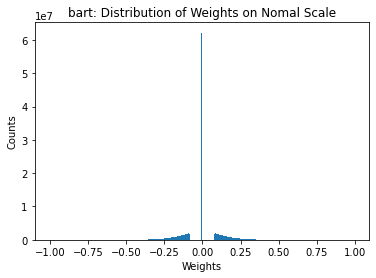

In [16]:
weights_dist_normal("bart", model, save=False)

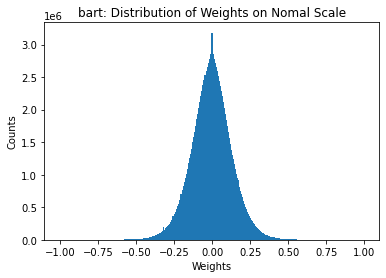

In [14]:
weights_dist_normal("bart", model, save=False)